In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Comparison of the K-Means and MiniBatchKMeans clustering algorithms
We want to compare the performance of the MiniBatchKMeans and KMeans: the MiniBatchKMeans is faster, but gives slightly different results (see Mini Batch K-Means).

We will cluster a set of data, first with KMeans and then with MiniBatchKMeans, and plot the results. We will also plot the points that are labelled differently between the two algorithms.

In [1]:
import numpy as np

from sklearn.datasets import make_blobs

np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

# Compute clustering with KMeans

In [2]:
import time

from sklearn.cluster import KMeans

k_means = KMeans(init="k-means++", n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

# Compute clustering with MiniBatchKMeans

In [3]:
from sklearn.cluster import MiniBatchKMeans

mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=3,
    batch_size=batch_size,
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

# Establishing parity between clusters
We want to have the same color for the same cluster from both the MiniBatchKMeans and the KMeans algorithm. Let’s pair the cluster centers per closest one.

In [5]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

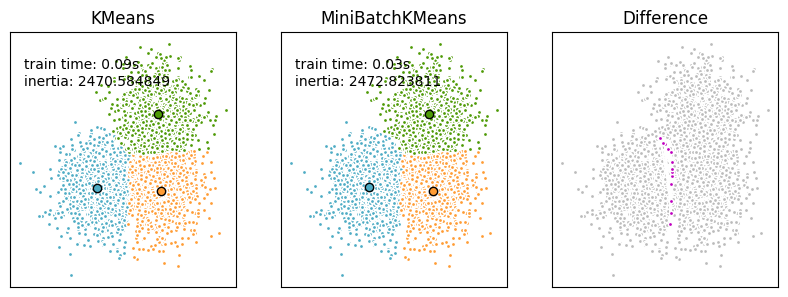

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("MiniBatchKMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_mini_batch, mbk.inertia_))

# Initialize the different array to all False
different = mbk_means_labels == 4
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += (k_means_labels == k) != (mbk_means_labels == k)

identical = np.logical_not(different)
ax.plot(X[identical, 0], X[identical, 1], "w", markerfacecolor="#bbbbbb", marker=".")
ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="m", marker=".")
ax.set_title("Difference")
ax.set_xticks(())
ax.set_yticks(())

plt.show()